In [1]:
import sys
sys.path.append('../../')

In [2]:
from scripts.utils import data_path, set_mpl, read_london, add_datetime_features, get_spectrogram
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
set_mpl()
%matplotlib widget

matplotlib settings set
matplotlib settings set


In [3]:
data_std, _, weather = read_london()

data_std = data_std.query('index>"2012-01-01"')
weather = weather.query('index>"2012-01-01"')


    Loading London data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Weather from `meteostat` package.

    STD and ToU tariffs are separated.
    Data resampled (mean) to 1H resolution from original 30min resolution.

    reutrns:
    df_std: pd.DataFrame with STD tariff data
    df_tou: pd.DataFrame with ToU tariff data
    df_weather: pd.DataFrame with weather data
    
    


In [4]:
missed_frac = data_std.isna().mean(axis = 0).sort_values(ascending = False)
#drop columns with more than xx% missing values
data = data_std.drop(missed_frac[missed_frac > 0.3].index, axis = 1)
homes_col = data.columns

cols = data.columns

#data['homes_num'] = data[cols].count(axis=1)
#data['power_avg'] = data[cols].sum(axis=1)/data['homes_num']

In [5]:
#select homes with mean energy consumption above between 0.1 and 0.13 
data_cluster = data[cols[ (data[cols].mean() > 0.1) & (data[cols].mean() < 0.13) ]]
power_avg = data_cluster.mean(axis=1).to_frame()
power_avg.columns = ['power_avg']


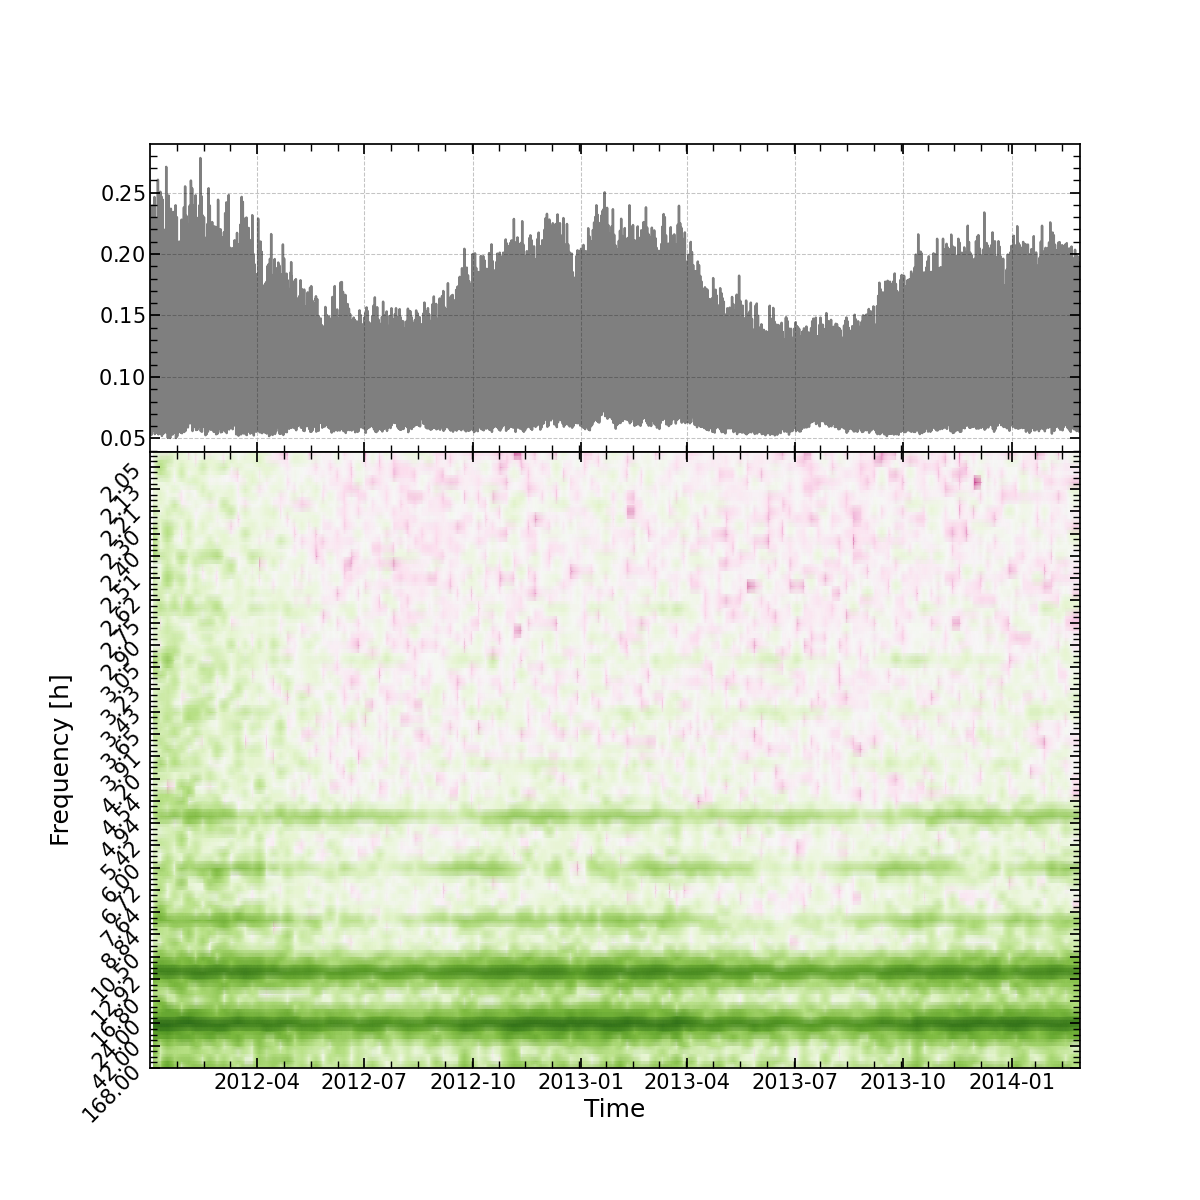

In [6]:
#get spectrogram
power_avg_spe = get_spectrogram(power_avg, 'power_avg', 24*7, 24, plot = True)
power_avg_spe = power_avg_spe/np.max(power_avg_spe, axis = 0)

In [8]:
#time series modelling with random forest and covariates

from darts import TimeSeries
from darts.metrics import mape
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr


target = TimeSeries.from_dataframe(power_avg, freq = 'H')

hodidays_covariates = target.add_holidays("UK")['holidays']

frequency_covariates = TimeSeries.from_dataframe(power_avg_spe[['24.00', '12.00', '6.00']], freq = 'H')


temperature_history = weather['temp']/np.max(weather['temp'])
#perturb temperature to avoid perfect correlation
rolling_std = temperature_history.rolling(24*3).std()
temperature_forecast = temperature_history + np.random.normal(0, rolling_std, size = len(temperature_history))

#temperature_covariate_past = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
#temperature_covariate_future  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
temperature_covariate  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H') #we can use it as past and future, although it is not perfect for past predictions


#datetime encodings (normalized)
datetime_covatiates = concatenate(
    [
        dt_attr(time_index = target.time_index, attribute =  "hour", one_hot = False, cyclic = False )/24,
        dt_attr(time_index = target.time_index, attribute =  "day_of_week", one_hot = False, cyclic = False )/7,
        dt_attr(time_index = target.time_index, attribute =  "month", one_hot = False, cyclic = False )/12,
        dt_attr(time_index = target.time_index, attribute =  "day_of_year", one_hot = False, cyclic = False )/365,
    ],
    axis="component",
)

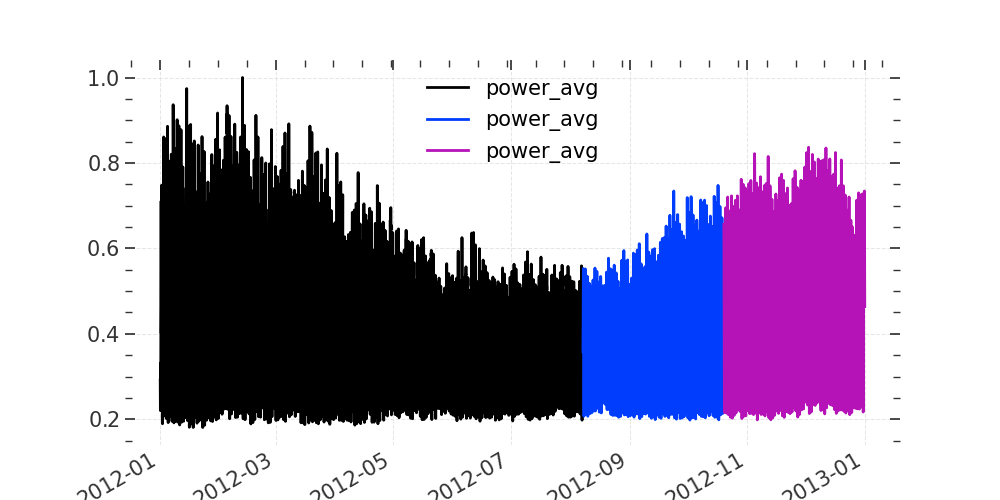

In [9]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, mase

from sklearn.preprocessing import MaxAbsScaler

target, _ = target.split_before(pd.Timestamp('2013-01-01'))
train, val = target.split_before(0.6)
val, test = val.split_before(0.5)

scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

val_len = len(val)


fig,  ax =  plt.subplots( figsize = (10,5))

train.plot(ax = ax)
val.plot(ax = ax)
test.plot(ax = ax)



In [15]:
from darts.models import RandomForest

lags_horizon = 1

model_naive = val.shift(+24) #repeat value from 24 hours ago

rf_args = {'lags': 24, 
        'n_estimators': 500, 'max_depth': 10,
        'max_features': 0.5, 'bootstrap': False}


model_rf_no_covariates = RandomForest(
                        **rf_args)

model_rf_no_covariates.fit(train)


model_rf = RandomForest(lags_future_covariates = (lags_horizon, lags_horizon) , lags_past_covariates=lags_horizon,
                    **rf_args)

model_rf.fit(train,
        future_covariates = [datetime_covatiates,hodidays_covariates],
        past_covariates = [frequency_covariates])



model_rf_no_freq = RandomForest(lags_future_covariates = (lags_horizon, lags_horizon),
                        **rf_args)

model_rf_no_freq.fit(train, 
        future_covariates = [datetime_covatiates,hodidays_covariates],)



models = [model_naive, model_rf_no_covariates, model_rf_no_freq, model_rf]
names = ['naive', 'rf_no_covariates', 'rf_no_freq', 'rf']

naive mape: 5.87839
rf_no_covariates mape: 5.36354
rf_no_freq mape: 4.9617
rf mape: 4.92034


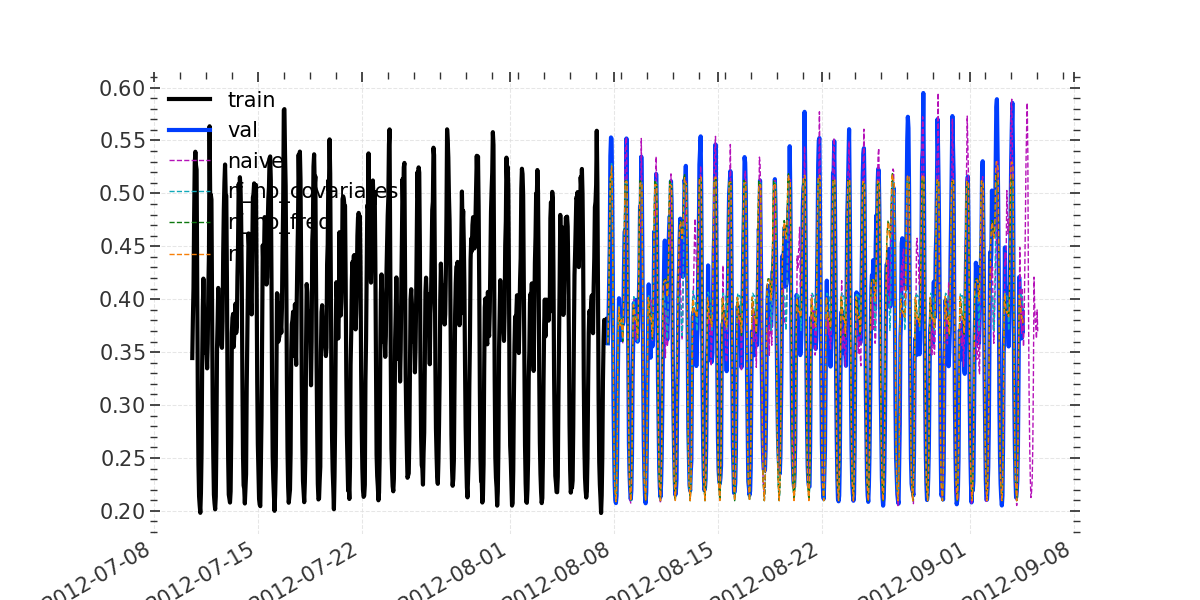

In [19]:
horizon = 24*7*4 #four week ahead


fig,  ax =  plt.subplots( figsize = (12,6))
train.tail(24).plot(ax = ax, label = 'train', lw = 3, alpha = 0.2)
val.head(horizon).plot(ax = ax, label = 'val', lw = 3, alpha = 0.2)

for model, name  in zip(models, names):
    try:
        pred = model.predict(horizon)
    except:
        pred = model 
    print(f'{name} mape: {mape(val, pred):3g}')
    pred.head(horizon).plot(ax = ax, label = name, ls = '--', lw = 1)



In [37]:
q

component,power_avg,power_avg
date,,
2012-08-07 14:00:00,0.358893,0.358328
2012-08-07 15:00:00,0.384016,0.381084
2012-08-07 16:00:00,0.428970,0.418228
2012-08-07 17:00:00,0.481503,0.449761
2012-08-07 18:00:00,0.514850,0.535315
...,...,...
2012-10-19 13:00:00,NaN,0.404762
2012-10-19 14:00:00,NaN,0.398046
2012-10-19 15:00:00,NaN,0.448928


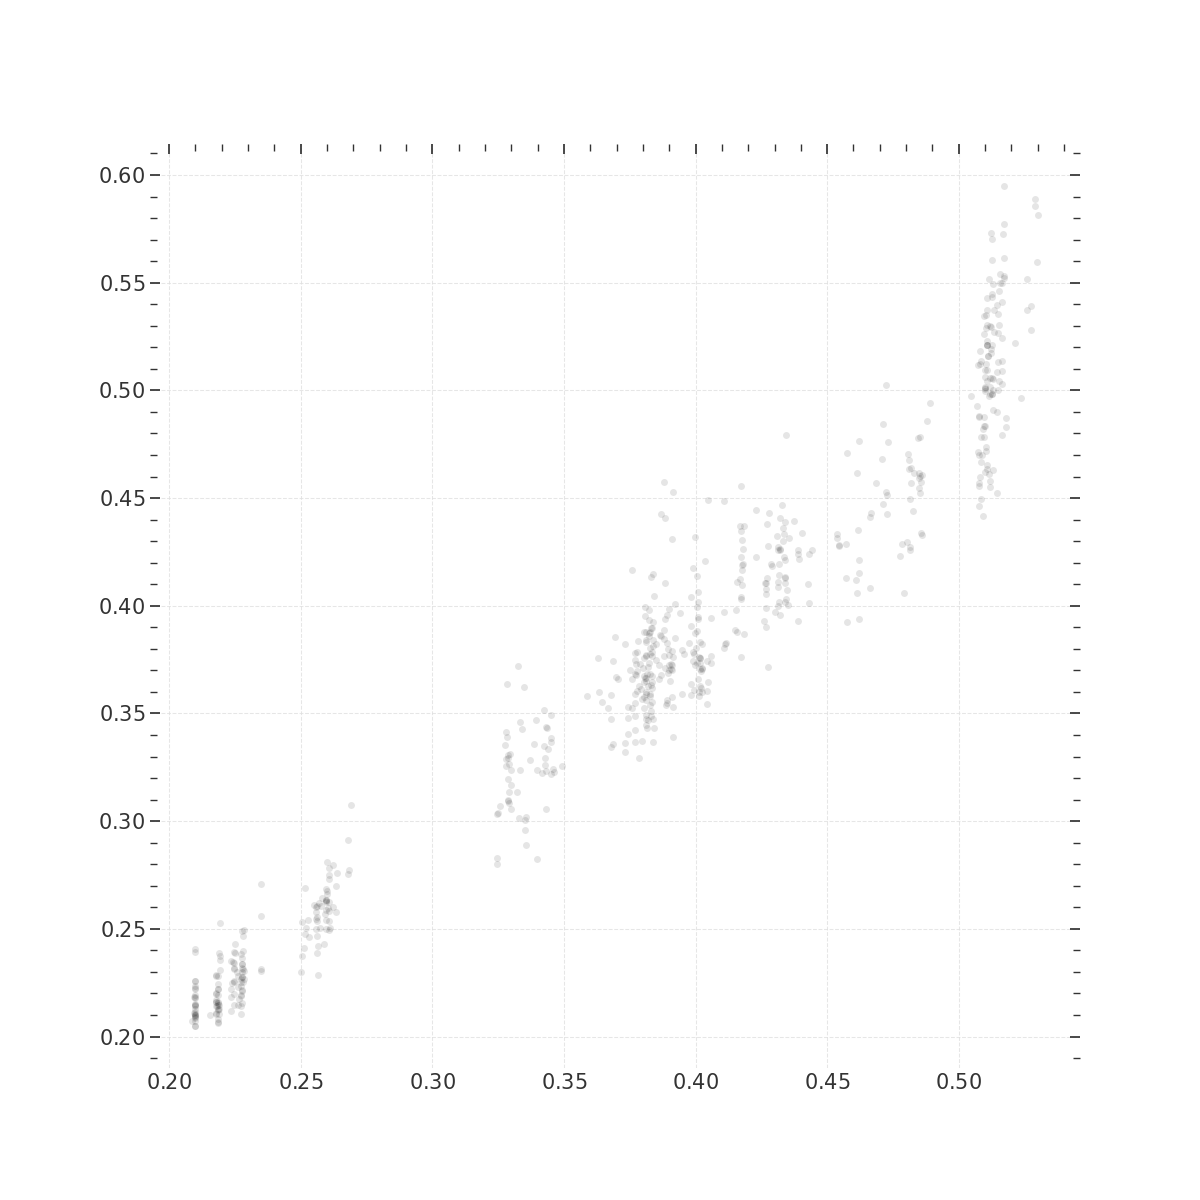

In [39]:
q = pd.concat([pred.pd_dataframe(), val.pd_dataframe()], axis = 1)
q.columns = ['pred', 'val']

fig,  ax =  plt.subplots( figsize = (12,12))

ax.plot(q['pred'], q['val'], 'o', alpha = 0.1)